In [1]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Flatten,Dense,Layer
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
#No need in colab

# gpu = tf.config.experimental.list_physical_devices('GPU')

# print(gpu)
# for i in gpu:
#     tf.config.experimental.set_memory_growth(i, True)

In [3]:
# for dir in os.listdir('lfw'):
#     for file in os.listdir('lfw/'+dir):
#         os.replace('lfw/'+dir+'/'+file, 'data/negative/'+file)



In [4]:
# video = cv2.VideoCapture(0)
# cnt = 0
# while True:
#     ret, frame = video.read()
#     frame = frame[120:400, 200:580]
#     cv2.imshow('frame', frame)
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord('q'):
#         break
#     elif key == ord('p'):
#         cv2.imwrite('data/positive/'+str(cnt)+'.jpg', frame)
#         cnt+=1

# video.release()
# cv2.destroyAllWindows()

In [5]:
#mounting about data uploaded in g drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip /content/drive/MyDrive/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/negative/Pierce_Brosnan_0010.jpg  
  inflating: data/negative/Patty_Duke_0001.jpg  
  inflating: data/negative/Ana_Palacio_0001.jpg  
  inflating: data/negative/Hugo_Chavez_0001.jpg  
  inflating: data/negative/Hugo_Chavez_0012.jpg  
  inflating: data/negative/Hugo_Chavez_0029.jpg  
  inflating: data/negative/Hugo_Chavez_0030.jpg  
  inflating: data/negative/Hugo_Chavez_0041.jpg  
  inflating: data/negative/Hugo_Chavez_0042.jpg  
  inflating: data/negative/Hugo_Chavez_0059.jpg  
  inflating: data/negative/Tariq_Aziz_0003.jpg  
  inflating: data/negative/Tariq_Aziz_0004.jpg  
  inflating: data/negative/Khalid_Qazi_0001.jpg  
  inflating: data/negative/Damon_van_Dam_0001.jpg  
  inflating: data/negative/Ari_Fleischer_0003.jpg  
  inflating: data/negative/Jeb_Bush_0010.jpg  
  inflating: data/negative/Al_Gore_0005.jpg  
  inflating: data/negative/Joschka_Fischer_0004.jpg  
  inflating: data/negative/Joschka_Fischer_0012.

In [7]:
anchor = tf.data.Dataset.list_files('/content/data/neutral/*.jpg')
positive = tf.data.Dataset.list_files('/content/data/positive/*.jpg')
negative = tf.data.Dataset.list_files('/content/data/negative/*.jpg').take(3000)

In [8]:
def pre_process(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [100, 100])
    img = img/255.0
    return img



In [9]:
#Labelled dataset
positives = tf.data.Dataset.zip((anchor, positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

dataset = positives.concatenate(negatives)

In [10]:
def pre_process_twin(input_img,val_img, label):
    return (pre_process(input_img), pre_process(val_img), label)

dataset = dataset.map(pre_process_twin)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)

In [11]:
size = 0.9*len(dataset)
train_dataset = dataset.take(int(size))
train_dataset = train_dataset.batch(32)
train_dataset = train_dataset.prefetch(8)

test_dataset = dataset.skip(int(size))
test_dataset = test_dataset.batch(32)
test_dataset = test_dataset.prefetch(8)



In [12]:
#Model
input = Input(shape=(100,100,3))
def embedding():
    c1 = Conv2D(64, (10,10), activation='relu')(input)
    p1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(p1)
    p2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(p2)
    p3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(p3)
    fl = Flatten()(c4)
    output =  Dense(4096, activation='sigmoid')(fl)
    return Model(input, output,name='embedding')

model = embedding()

In [13]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self,input_embedding, val_embedding):
        return tf.math.abs(input_embedding-val_embedding)
l1 = L1Dist()

In [14]:
def siamese_network():
    input_img = Input(shape=(100,100,3))
    val_img = Input(shape=(100,100,3))
    input_embed = model(input_img)
    val_embed = model(val_img)
    distance = l1(input_embed, val_embed)
    output = Dense(1, activation='sigmoid')(distance)
    print(Model([input_img, val_img], output).summary())
    return Model([input_img, val_img], output)
siamese_model =  siamese_network()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_2[0][0]',             
                                                          8          'input_3[0][0]']             
                                                                                                  
 l1_dist (L1Dist)            (None, 4096)                 0         ['embedding[0][0]',       

In [15]:
binary_cross = tf.losses.BinaryCrossentropy()
optimizer = Adam(0.0001)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=siamese_model)


In [16]:
@tf.function

def train_step(batch):
    with tf.GradientTape() as tape:
        X =batch[:2]
        Y = batch[2]
        y_hat = siamese_model(X)
        loss = binary_cross(Y, y_hat)
    print(loss)
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss




In [17]:
def train(data,EPOCHS):
    for epoch in tqdm(range(1,EPOCHS+1)):
        for batch in data:
            loss = train_step(batch)
        print('Epoch: {} Loss: {}'.format(epoch, loss))
        if epoch % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)


In [18]:
train(train_dataset,50)

  0%|          | 0/50 [00:00<?, ?it/s]

Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


  2%|▏         | 1/50 [00:12<09:55, 12.16s/it]

Epoch: 1 Loss: 0.6808748841285706


  4%|▍         | 2/50 [00:12<04:14,  5.30s/it]

Epoch: 2 Loss: 0.6333690881729126


  6%|▌         | 3/50 [00:13<02:26,  3.11s/it]

Epoch: 3 Loss: 0.5944868326187134


  8%|▊         | 4/50 [00:13<01:35,  2.08s/it]

Epoch: 4 Loss: 0.503393292427063
Epoch: 5 Loss: 0.3772161304950714


 12%|█▏        | 6/50 [00:16<01:06,  1.51s/it]

Epoch: 6 Loss: 0.47509464621543884


 14%|█▍        | 7/50 [00:16<00:50,  1.18s/it]

Epoch: 7 Loss: 0.36784759163856506


 16%|█▌        | 8/50 [00:17<00:40,  1.04it/s]

Epoch: 8 Loss: 0.37277549505233765


 18%|█▊        | 9/50 [00:17<00:33,  1.23it/s]

Epoch: 9 Loss: 0.2788695991039276
Epoch: 10 Loss: 0.30507051944732666


 22%|██▏       | 11/50 [00:25<01:24,  2.15s/it]

Epoch: 11 Loss: 0.2239752560853958


 24%|██▍       | 12/50 [00:26<01:02,  1.65s/it]

Epoch: 12 Loss: 0.3441327214241028


 26%|██▌       | 13/50 [00:26<00:48,  1.30s/it]

Epoch: 13 Loss: 0.13928477466106415


 28%|██▊       | 14/50 [00:27<00:38,  1.06s/it]

Epoch: 14 Loss: 0.20985223352909088
Epoch: 15 Loss: 0.21241243183612823


 32%|███▏      | 16/50 [00:30<00:44,  1.32s/it]

Epoch: 16 Loss: 0.16570645570755005


 34%|███▍      | 17/50 [00:31<00:35,  1.07s/it]

Epoch: 17 Loss: 0.15747690200805664


 36%|███▌      | 18/50 [00:31<00:28,  1.11it/s]

Epoch: 18 Loss: 0.0748969241976738


 38%|███▊      | 19/50 [00:32<00:24,  1.28it/s]

Epoch: 19 Loss: 0.08972065150737762
Epoch: 20 Loss: 0.08619606494903564


 42%|████▏     | 21/50 [00:35<00:31,  1.08s/it]

Epoch: 21 Loss: 0.03670087829232216


 44%|████▍     | 22/50 [00:35<00:25,  1.11it/s]

Epoch: 22 Loss: 0.03935237601399422


 46%|████▌     | 23/50 [00:36<00:21,  1.28it/s]

Epoch: 23 Loss: 0.020552996546030045


 48%|████▊     | 24/50 [00:36<00:18,  1.43it/s]

Epoch: 24 Loss: 0.013658053241670132
Epoch: 25 Loss: 0.012355063110589981


 52%|█████▏    | 26/50 [00:39<00:21,  1.09it/s]

Epoch: 26 Loss: 0.0037100983317941427


 54%|█████▍    | 27/50 [00:39<00:18,  1.27it/s]

Epoch: 27 Loss: 0.004396436270326376


 56%|█████▌    | 28/50 [00:40<00:15,  1.42it/s]

Epoch: 28 Loss: 0.007182643748819828


 58%|█████▊    | 29/50 [00:40<00:13,  1.56it/s]

Epoch: 29 Loss: 0.002222998533397913
Epoch: 30 Loss: 0.001570407534018159


 62%|██████▏   | 31/50 [00:43<00:16,  1.13it/s]

Epoch: 31 Loss: 0.0020920264068990946


 64%|██████▍   | 32/50 [00:43<00:13,  1.30it/s]

Epoch: 32 Loss: 0.0015138674061745405


 66%|██████▌   | 33/50 [00:44<00:11,  1.46it/s]

Epoch: 33 Loss: 0.0029529535677284002


 68%|██████▊   | 34/50 [00:44<00:10,  1.58it/s]

Epoch: 34 Loss: 0.000983685371465981
Epoch: 35 Loss: 0.000660007877741009


 72%|███████▏  | 36/50 [00:49<00:20,  1.50s/it]

Epoch: 36 Loss: 0.0004254138912074268


 74%|███████▍  | 37/50 [00:50<00:15,  1.20s/it]

Epoch: 37 Loss: 0.0008772439905442297


 76%|███████▌  | 38/50 [00:50<00:11,  1.01it/s]

Epoch: 38 Loss: 0.0006153215072117746


 78%|███████▊  | 39/50 [00:51<00:09,  1.19it/s]

Epoch: 39 Loss: 0.00017684153863228858
Epoch: 40 Loss: 0.0002549277269281447


 82%|████████▏ | 41/50 [00:56<00:13,  1.46s/it]

Epoch: 41 Loss: 0.00026454663020558655


 84%|████████▍ | 42/50 [00:56<00:09,  1.17s/it]

Epoch: 42 Loss: 0.0003183140652254224


 86%|████████▌ | 43/50 [00:57<00:06,  1.03it/s]

Epoch: 43 Loss: 0.0001778125442797318


 88%|████████▊ | 44/50 [00:57<00:04,  1.20it/s]

Epoch: 44 Loss: 0.0005843003746122122
Epoch: 45 Loss: 0.00015887313929852098


 92%|█████████▏| 46/50 [01:05<00:08,  2.11s/it]

Epoch: 46 Loss: 0.00035081052919849753


 94%|█████████▍| 47/50 [01:06<00:04,  1.63s/it]

Epoch: 47 Loss: 0.00035422109067440033


 96%|█████████▌| 48/50 [01:06<00:02,  1.29s/it]

Epoch: 48 Loss: 0.0003083520568907261


 98%|█████████▊| 49/50 [01:07<00:01,  1.05s/it]

Epoch: 49 Loss: 0.00025289575569331646
Epoch: 50 Loss: 0.0002620590094011277


100%|██████████| 50/50 [01:09<00:00,  1.39s/it]


In [19]:
from tensorflow.keras.metrics import Accuracy, Recall, Precision

test_inp,test_val,label = test_dataset.as_numpy_iterator().next()
y_hat = siamese_model([test_inp, test_val])
res = []
for i in y_hat:
    if i > 0.5:
        res.append(1)
    else:
        res.append(0)

acc = Accuracy()
acc.update_state(label,res)

recall = Recall()
recall.update_state(label,res)

precision = Precision()
precision.update_state(label,res)

print('Accuracy:', acc.result().numpy())
print('Recall:', recall.result().numpy())
print('Precision:', precision.result().numpy())


Accuracy: 1.0
Recall: 1.0
Precision: 1.0


In [20]:
siamese_model.save('siamese_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
test_model = tf.keras.models.load_model('siamese_model.h5',custom_objects={'L1Dist':L1Dist})


In [22]:
def verification(input_img,val_img):

    img = cv2.imread(input_img)
    img = pre_process(input_img)
    img = tf.expand_dims(img,0)

    val = cv2.imread(val_img)
    val = pre_process(val_img)
    val = tf.expand_dims(val,0)

    y_hat = test_model([img,val])

    img = tf.squeeze(img)
    val = tf.squeeze(val)

    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(val)

    if y_hat > 0.5:
        print('\n\n')
        print('Same person')
        print('\n\n')
    else:
        print('\n\n')
        print('Different person')
        print('\n\n')



Saving 0.jpg to 0.jpg


Saving 3.jpg to 3.jpg



Same person





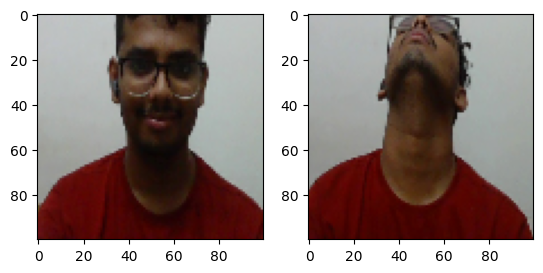

In [42]:
from google.colab import files

input_upload = files.upload()
input_img = list(input_upload.keys())[0]

val_upload = files.upload()
val_img = list(val_upload.keys())[0]

verification(input_img,val_img)
os.remove(input_img)
os.remove(val_img)

